In [1]:
%run common_init.py

Start import
Host: DESKTOP-EC5OUSI.localdomain
calculating effective efficiency for Xe detector done
calculating effective efficiency for Ge detector done
calculating effective efficiency for Ar detector done
calculating effective efficiency for Xe_migd detector done
calculating effective efficiency for Ge_migd detector done
calculating effective efficiency for Ar_migd detector done
nestle.py::
DEPRICATED
use NestedSamplerStatModel with self.sampler = nestle instead
Done import
SYSTEM
	Running on linux
	Python version 3.7.4 (default, Aug 13 2019, 20:35:49) [GCC 7.3.0]
	Python installation /home/joran/.conda/envs/DD_DM/bin/python
MODULES
	DirectDmTargets
		ver.:	0.2.0
		Path:	/mnt/c/Users/Joran/Google Drive/PhD-master/ubuntu-storage/windows-anaconda/DD_DM_targets/DirectDmTargets/

	wimprates
		ver.:	0.3.2
		Path:	/mnt/c/Users/Joran/Google Drive/PhD-master/ubuntu-storage/windows-anaconda/forked_wimprates/wimprates/



# Direct detection of Dark matter using different target materials #

Author:

Joran Angevaare <j.angevaare@nikef.nl>

Date:

14 october 2019 

## Goal ## 

- Roughly reproduce <https://journals.aps.org/prd/abstract/10.1103/PhysRevD.83.083505>
- Update the results thereof with more recent knowledge of the DM-distribution

### Approach ###
To achieve these goals, we must first get a decent recoil spectrum, that is flexible enough to have different astrophysical parameters. Further, it must also be flexible enough to be able to allow for different analytic functions to be added to the model. For instance, we must be able to incorporate the $\rm{SHM}^{++}$ as presented here <https://arxiv.org/abs/1810.11468>.

When we have a sufficiently flexible model, we want to add in the detector physics, we should therein incorporate at least the following parameters:
- target
  - material
  - cross-section
- threshold
- background
- cut efficiency  
- volume
- exposure

Finally we should perform the inference

In [2]:
import nestle

# Emcee #
<https://emcee.readthedocs.io/en/stable/tutorials/quickstart/>

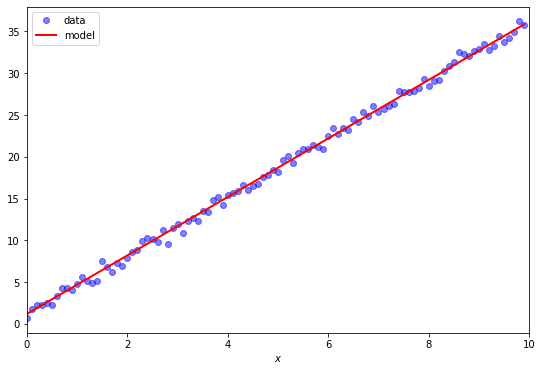

In [3]:
from scipy.special import ndtri

def prior_transform(theta):
    """
    https://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/#Nested-Sampling
    A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters.

    Args:
        theta (tuple): a tuple containing the parameters.
        
    Returns:
        tuple: a new tuple or array with the transformed parameters.
    """

    mprime, cprime = theta # unpack the parameters (in their unit hypercube form)

    cmin = -10.  # lower bound on uniform prior on c
    cmax = 10.   # upper bound on uniform prior on c

    mmu = 0.     # mean of Gaussian prior on m
    msigma = 10. # standard deviation of Gaussian prior on m

    m = mmu + msigma*ndtri(mprime) # convert back to m
    c = cprime*(cmax-cmin) + cmin  # convert back to c

    return (m, c)

# set the natural logarithm of 2pi, so that it doesn't have to be recalculated
LN2PI = np.log(2.*np.pi)
LNSIGMA = np.log(0.5) # natural log of the data noise standard deviation
M = 100

# set the true values of the model parameters for creating the data
m = 3.5 # gradient of the line
c = 1.2 # y-intercept of the line

# set the "predictor variable"/abscissa
M = 100
xmin = 0.
xmax = 10.
stepsize = (xmax-xmin)/M
x = np.arange(xmin, xmax, stepsize)

# define the model function
def straight_line(x, m, c):
    """
    A straight line model: y = m*x + c
    
    Args:
        x (list): a set of abscissa points at which the model is defined
        m (float): the gradient of the line
        c (float): the y-intercept of the line
    """

    return m*x + c

# seed our random number generator, so we have reproducible data
np.random.seed(sum([ord(v) for v in 'samplers']))

# create the data - the model plus Gaussian noise
sigma = 0.5 # standard deviation of the noise
data = straight_line(x, m, c) + sigma*np.random.randn(M)

# plot the data
# mpl.rcParams.update(rcparams) # update plot parameters
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(x, data, 'bo', alpha=0.5, label='data')
ax.plot(x, straight_line(x, m, c), 'r-', lw=2, label='model')
ax.legend()
ax.set_xlim([xmin, xmax])
ax.set_xlabel(r'$x$');

def loglikelihood_nestle(theta):
    """
    The log-likelihood function.
    """

    m, c = theta # unpack the parameters

    # normalisation
    norm = -0.5*M*LN2PI - M*LNSIGMA

    # chi-squared (data, sigma and x are global variables defined early on in this notebook)
    chisq = np.sum(((data-straight_line(x, m, c))/sigma)**2)

    return norm - 0.5*chisq

In [4]:
nlive = 1024     # number of live points
method = 'multi' # use MutliNest algorithm
ndims = 2        # two parameters
tol = 0.1        # the stopping criterion

t0 = time.time()
res = nestle.sample(loglikelihood_nestle, 
                    prior_transform, ndims, 
                    method=method, npoints=nlive, dlogz=tol)
t1 = time.time()

timenestle = (t1-t0)

print("Time taken to run 'Nestle' is {} seconds".format(timenestle))

Time taken to run 'Nestle' is 4.414428234100342 seconds


In [5]:
logZnestle = res.logz                         # value of logZ
infogainnestle = res.h                        # value of the information gain in nats
logZerrnestle = np.sqrt(infogainnestle/nlive) # estimate of the statistcal uncertainty on logZ

print('log(Z) = {} \u00B1 {}'.format(logZnestle, logZerrnestle))
print(res.summary())

# re-scale weights to have a maximum of one
nweights = res.weights/np.max(res.weights)

# get the probability of keeping a sample from the weights
keepidx = np.where(np.random.rand(len(nweights)) < nweights)[0]

# get the posterior samples
samples_nestle = res.samples[keepidx,:]
resdict ={}
resdict['mnestle_mu'] = np.mean(samples_nestle[:,0])      # mean of m samples
resdict['mnestle_sig'] = np.std(samples_nestle[:,0])      # standard deviation of m samples
resdict['cnestle_mu'] = np.mean(samples_nestle[:,1])      # mean of c samples
resdict['cnestle_sig'] = np.std(samples_nestle[:,1])      # standard deviation of c samples
resdict['ccnestle'] = np.corrcoef(samples_nestle.T)[0,1]  # correlation coefficient between parameters
resdict['nestle_npos'] = len(samples_nestle)              # number of posterior samples
resdict['nestle_time'] = timenestle                       # run time
resdict['nestle_logZ'] = logZnestle                       # log marginalised likelihood
resdict['nestle_logZerr'] = logZerrnestle                 # uncertainty on log(Z)

print('Number of posterior samples is {}'.format(len(samples_nestle)))

log(Z) = -87.7909519644676 ± 0.1011124677107491
niter: 14157
ncall: 22994
nsamples: 15181
logz: -87.791 +/-  0.101
h: 10.469
Number of posterior samples is 2765


In [6]:
print(res.summary())

niter: 14157
ncall: 22994
nsamples: 15181
logz: -87.791 +/-  0.101
h: 10.469


In [7]:
# re-scale weights to have a maximum of one
nweights = res.weights/np.max(res.weights)

# get the probability of keeping a sample from the weights
keepidx = np.where(np.random.rand(len(nweights)) < nweights)[0]

# get the posterior samples
samples_nestle = res.samples[keepidx,:]
resdict ={}
resdict['mnestle_mu'] = np.mean(samples_nestle[:,0])      # mean of m samples
resdict['mnestle_sig'] = np.std(samples_nestle[:,0])      # standard deviation of m samples
resdict['cnestle_mu'] = np.mean(samples_nestle[:,1])      # mean of c samples
resdict['cnestle_sig'] = np.std(samples_nestle[:,1])      # standard deviation of c samples
resdict['ccnestle'] = np.corrcoef(samples_nestle.T)[0,1]  # correlation coefficient between parameters
resdict['nestle_npos'] = len(samples_nestle)              # number of posterior samples
resdict['nestle_time'] = timenestle                       # run time
resdict['nestle_logZ'] = logZnestle                       # log marginalised likelihood
resdict['nestle_logZerr'] = logZerrnestle                 # uncertainty on log(Z)

print('Number of posterior samples is {}'.format(len(samples_nestle)))

Number of posterior samples is 2811


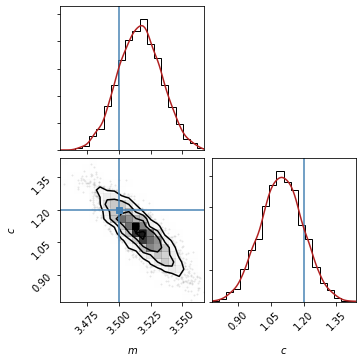

In [8]:
from scipy.stats import gaussian_kde
import corner
def plotposts(samples, **kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """
    if "truths" not in kwargs:
        kwargs["truths"] = [m, c]
    
    fig = corner.corner(samples, labels=[r'$m$', r'$c$'], hist_kwargs={'density': True}, **kwargs)

    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 3], samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')
plotposts(samples_nestle)

In [9]:
# import the Solver class
import pymultinest
from pymultinest.solve import Solver
from scipy.special import ndtri

LN2PI = np.log(2.*np.pi)

class StraightLineModelPyMultiNest(Solver):
    """
    A simple straight line model, with a Gaussian likelihood.

    Args:
        data (:class:`numpy.ndarray`): an array containing the observed data
        abscissa (:class:`numpy.ndarray`): an array containing the points at 
        which the data were taken
        modelfunc (function): a function defining the model
        sigma (float): the standard deviation of the noise in the data
        **kwargs: keyword arguments for the run method
    """

    # define the prior parameters
    cmin = -10.  # lower range on c (the same as the uniform c prior lower bound)
    cmax = 10.   # upper range on c (the same as the uniform c prior upper bound)

    mmu = 0.     # mean of the Gaussian prior on m
    msigma = 10. # standard deviation of the Gaussian prior on m

    def __init__(self, data, abscissa, modelfunc, sigma, **kwargs):
        # set the data
        self._data = data         # oberserved data
        self._abscissa = abscissa # points at which the observed data are taken
        self._sigma = sigma       # standard deviation(s) of the data
        self._logsigma = np.log(sigma) # log sigma here to save computations in the likelihood
        self._ndata = len(data)   # number of data points
        self._model = modelfunc   # model function

        Solver.__init__(self, **kwargs)

    def Prior(self, cube):
        """
        The prior transform going from the unit hypercube to the true parameters. This function
        has to be called "Prior".

        Args:
            cube (:class:`numpy.ndarray`): an array of values drawn from the unit hypercube

        Returns:
            :class:`numpy.ndarray`: an array of the transformed parameters
        """

        # extract values
        mprime = cube[0]
        cprime = cube[1]

        m = self.mmu + self.msigma*ndtri(mprime)      # convert back to m
        c = cprime*(self.cmax-self.cmin) + self.cmin  # convert back to c

        return np.array([m, c])

    def LogLikelihood(self, cube):
        """
        The log likelihood function. This function has to be called "LogLikelihood".

        Args:
            cube (:class:`numpy.ndarray`): an array of parameter values.

        Returns:
            float: the log likelihood value.
        """

        # extract parameters
        m = cube[0]
        c = cube[1]

        # calculate the model
        model = self._model(x, m, c)

        # normalisation
        norm = -0.5*self._ndata*LN2PI - self._ndata*self._logsigma

        # chi-squared
        chisq = np.sum(((self._data - model)/(self._sigma))**2)

        return norm - 0.5*chisq

In [10]:
# %%capture
nlive = 1024 # number of live points
ndim = 2     # number of parameters
tol = 0.5    # stopping criterion

# run the algorithm
t0 = time.time()
solution = StraightLineModelPyMultiNest(data, x, straight_line, sigma, n_dims=ndim,
                                        n_live_points=nlive, evidence_tolerance=tol);
t1 = time.time()

timepymultinest = (t1-t0)



  analysing data from /tmp/tmpegoreegrpymultinest/.txt


In [11]:
timepymultinest

15.307499408721924

In [12]:
from datetime import datetime

In [13]:
from pymultinest.solve import solve as multines_solve

In [14]:
from DirectDmTargets import get_param_list, StatModel, log_likelihood
class PyMultinestStatModel(StatModel):
    known_parameters = get_param_list()

    def __init__(self, *args):
        StatModel.__init__(self, *args)
        self.tol = 0.1
        self.nlive = 1024
        self.log = {'did_run': False, 'saved_in': None}
        self.config['start'] = datetime.now()  # .date().isoformat()
        self.config['notes'] = "default"
        self.result = False
        self.set_fit_parameters(['log_mass', 'log_cross_section'])
        if self.verbose:
            print(f'PyMultinestStatModel::\t{now()}\n\tVERBOSE ENABLED')
            if self.verbose > 1:
                print(f"PyMultinestStatModel::\t{now()}\n\tSUPERVERBOSE ENABLED\n\tyou want to "
                      f"know it all? Here we go sit back and be blown by my output!")
#         Solver.__init__(self, **kwargs)

    def set_fit_parameters(self, params):
        if self.verbose:
            print(f'PyMultinestStatModel::\t{now()}\n\tsetting fit parameters to {params}')
        if not type(params) == list:
            raise TypeError("Set the parameter names in a list of strings")
        for param in params:
            if param not in self.known_parameters:
                err_message = f"{param} does not match any of the known parameters try any of {self.known_parameters}"
                raise NotImplementedError(err_message)
        if not params == self.known_parameters[:len(params)]:
            err_message = f"The parameters are not input in the correct order. Please" \
                          f" insert {self.known_parameters[:len(params)]} rather than {params}."
            raise NameError(err_message)
        self.fit_parameters = params

    def check_did_run(self):
        if self.verbose:
            print(f'PyMultinestStatModel::\t{now()}\n\tdid not run yet, lets fire it up!')
        if not self.log['did_run']:
            self.run_nestle()

    def check_did_save(self):
        if self.verbose:
            print(f'PyMultinestStatModel::\t{now()}\n\tdid not save yet, we dont want to lose '
                  f'our results so better do it now')
        if self.log['saved_in'] is None:
            self.save_results()

    def log_probability_nestle(self, parameter_vals, parameter_names):
        """

        :param parameter_vals: the values of the model/benchmark considered as the truth
        # :param parameter_values: the values of the parameters that are being varied
        :param parameter_names: the names of the parameter_values
        :return:
        """
        # if self.verbose:
        #     print(f"'"PyMultinestStatModel::\t{now()}\n\t
        if self.verbose > 1:
            print(f"PyMultinestStatModel::\t{now()}\n\tSUPERVERBOSE\tthere we go! Find that log probability")
        evaluated_rate = self.eval_spectrum(parameter_vals, parameter_names)[
            'counts']

        ll = log_likelihood(self.benchmark_values, evaluated_rate)
        if np.isnan(ll):
            raise ValueError(
                f"Returned NaN from likelihood. ll = {ll}")
        if self.verbose > 1:
            print(f"PyMultinestStatModel::\t{now()}\n\tSUPERVERBOSE\tfound it! returning the log likelihood")
        return ll

    def log_prior_transform_nestle(self, x, x_name):
        if self.verbose > 1:
            print(f"PyMultinestStatModel::\t{now()}\n\tSUPERVERBOSE\tdoing some transformations for nestle "
                  f"to read the priors")
        if self.config['prior'][x_name]['prior_type'] == 'flat':
            a, b = self.config['prior'][x_name]['param']
            return x * (b - a) + a
        elif self.config['prior'][x_name]['prior_type'] == 'gauss':
            a, b = self.config['prior'][x_name]['range']
            m, s = self.config['prior'][x_name]['param']
            aprime = spsp.ndtr((a - m) / s)
            bprime = spsp.ndtr((b - m) / s)
            xprime = x * (bprime - aprime) + aprime
            res = m + s * spsp.ndtri(xprime)
            return res
        else:
            err_message = f"unknown prior type '{self.config['prior'][x_name]['prior_type']}', " \
                          f"choose either gauss or flat"
            raise TypeError(err_message)

    def _log_probability_nestle(self, theta):
        if self.verbose > 1:
            print(f"PyMultinestStatModel::\t{now()}\n\tSUPERVERBOSE\tdoing _log_probability_nestle"
                  f"\n\t\tooph, what a nasty function to do some transformations behind the scenes")
        ndim = len(theta)
        return self.log_probability_nestle(theta, self.known_parameters[:ndim])

    def _log_prior_transform_nestle(self, theta):
        if self.verbose > 1:
            print(f"PyMultinestStatModel::\t{now()}\n\tSUPERVERBOSE\tdoing _log_prior_transform_nestle"
                  f"\n\t\tooph, what a nasty function to do some transformations behind the scenes")
        result = [self.log_prior_transform_nestle(val, self.known_parameters[i]) for i, val in enumerate(theta)]
        return np.array(result)

#     def Prior(self, cube):
#         return self._log_prior_transform_nestle(cube)

#     def LogLikelihood(self, cube):
#         return self._log_probability_nestle(cube)

In [15]:
stats = PyMultinestStatModel('Xe')

StatModel::	2020-01-20T17:04
	initialized for Xe detector.See print(stat_model) for default settings


In [16]:
stats._log_probability_nestle([0,0])

-253433.04904078602

In [17]:
time.time()

1579536300.2681744

In [22]:
from pymultinest.solve import solve

In [18]:
from __future__ import absolute_import, unicode_literals, print_function
import numpy
from numpy import pi, cos

In [ ]:
%time
start_multi = time.time()

result = solve(LogLikelihood=stats._log_probability_nestle, 
      Prior=stats._log_prior_transform_nestle,
      n_dims = 2,
      outputfiles_basename = 'temp_res2',
      verbose=True,
     )
end_multi = time.time()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.8 µs


In [ ]:
end_multi - start_multi

In [ ]:
parameters = ["x", "y"]

In [ ]:
print()
print('evidence: %(logZ).1f +- %(logZerr).1f' % result)
print()
print('parameter values:')
for name, col in zip(parameters, result['samples'].transpose()):
	print('%15s : %.3f +- %.3f' % (name, col.mean(), col.std()))

In [ ]:
import json
with open('%sparams.json' % '.', 'w') as f:
    json.dump(parameters, f, indent=2)

In [ ]:
# solution = PyMultinestStatModel('Xe', 
#                                 n_dims=ndim,
#                                 n_live_points=nlive, 
#                                 evidence_tolerance=tol)

In [ ]:
# solution

In [ ]:
stats2 = dddm.NestedSamplerStatModel('Xe')

stats2.nlive = 200
stats2.verbose = 0

In [ ]:
start_nestle = time.time()
stats2.run_nestle()
end_nestle = time.time()

In [ ]:
end_nestle - start_nestle

In [ ]:
stats2.get_summary()

In [ ]:
%run common_init.py

In [ ]:
stats3 = dddm.NestedSamplerStatModel('Xe')

stats3.nlive = 200
stats3.verbose = 1
stats3.sampler = 'multinest'

In [ ]:
start_nestle = time.time()
stats3.run_multinest()
end_nestle = time.time()

In [ ]:
end_nestle - start_nestle

In [ ]:
from pymultinest import Analyzer

In [ ]:
# create analyzer object
a = Analyzer(2, outputfiles_basename = "results/nested_multinest4/multinest")

# get a dictionary containing information about
#   the logZ and its errors
#   the individual modes and their parameters
#   quantiles of the parameter posteriors
stats = a.get_stats()

# get the best fit (highest likelihood) point
bestfit_params = a.get_best_fit()

# iterate through the "posterior chain"
# for params in a.get_equal_weighted_posterior():
#         print (params)

In [ ]:
a.get_best_fit()

In [ ]:
assert False

## Distribution of the DM ##
First we need to make a DM-rate spectrum

In [ ]:
stats_full = dddm.NestedSamplerStatModel('Xe_migd')

stats_full.nlive = 200
stats_full.verbose = 1
stats_full.sampler = 'multinest'

In [ ]:
stats_full.log
stats_full.set_prior('migdal_lower')

In [ ]:
# for key in stats_full.log.keys():
#     stats_full.log[key] = False


In [ ]:
stats_full.fit_parameters = stats_full.known_parameters

In [ ]:
stats_full.check_spectrum()

In [ ]:
start = time.time()
stats_full.run_multinest()
end = time.time()

In [ ]:
end-start

In [ ]:
stats_full.save_results()

In [ ]:
9170.64813709259/3600

In [ ]:
assert stats_full.log['did_run']

In [ ]:
stats_full.show_walkers()

In [ ]:
stats_full.show_corner()

In [ ]:
corner.corner(
    stats_full.sampler.get_chain(
        flat=True,
        thin = 50,
        discard=int(stats_full.nsteps * 0.2)
    ),
              labels=stats_full.fit_parameters);